[DIY Covid-19 Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) (C) Fabrizio Smeraldi, 2020 ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)). This notebook is released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).

# DIY Covid-19 Dashboard

This is a template for your DIY Covid Dashboard, to which you can add the code you developed in the previous notebooks. The dashboard will be displayed using [voila](https://voila.readthedocs.io/en/stable/index.html), a Python dashboarding tool that converts notebooks to standalone dashboards. Contrary to the other libraries we have seen, the ```voila``` package must be installed using *pip* or *conda* but it does not need to be imported - it rather acts at the level of the notebook server. Package ```voila``` is already installed on the QMUL JupyterHub as well as in the Binder - to install it locally, follow the [instructions](https://voila.readthedocs.io/en/stable/install.html) online.

Broadly speaking, Voila acts by **running all the cells in your notebook** when the dashboard is first loaded; it then hides all code cells and displays all markdown cells and any outputs, including widgets. However, the code is still there in the background and handles any interaction with the widgets. To view this dashboard template rendered in Voila click [here](https://mybinder.org/v2/gh/fsmeraldi/diy-covid19dash/main?urlpath=%2Fvoila%2Frender%2FDashboard.ipynb).

In [44]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [45]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## Load initial data from disk

You should include "canned" data in ```.json``` files along with your dashboard. When the dashboard starts, it should load that data and assign it as a dictionary to the ```jsondata``` variable (the code below will be hidden when the dashboard is rendered by Voila).

In [46]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
# Show A Comparison of Hospital Admissions with Ventilator Bed Occupancy in England
import json
with open("hosptial.json", "r") as json_file:
    jsondata = json.load(json_file)

## Wrangle the data

The dashboard should contain the logic to wrangle the raw data into a ```DataFrame``` (or more than one, as required) that will be used for plotting. The wrangling code should be put into a function and called on the data from the JSON file (we'll need to call it again on any data downloaded from the API).  In this template, we just pretend we are wrangling ```rawdata``` and instead generate a dataframe with some random data

In [47]:
import pandas as pd
import numpy as np
def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe. """
    
    datalist = rawdata['data']
    dates = [dictionary['date'] for dictionary in datalist]
    dates.sort()

    def parse_date(datestring):
        return pd.to_datetime(datestring, format="%Y-%m-%d")

    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])

    index = pd.date_range(startdate, enddate, freq='D')
    hospitaldf = pd.DataFrame(index=index, columns=['newAdmissions', 'covidOccupiedMVBeds'])

    for entry in datalist:
        date = parse_date(entry['date'])
        for column in ['newAdmissions', 'covidOccupiedMVBeds']:
            if pd.isna(hospitaldf.loc[date, column]):
                value = float(entry[column]) if entry[column] != None else 0.0
                hospitaldf.loc[date, column] = value

    hospitaldf.fillna(0.0, inplace=True)

    return hospitaldf

# call wrangle_data to df
df = wrangle_data(jsondata)

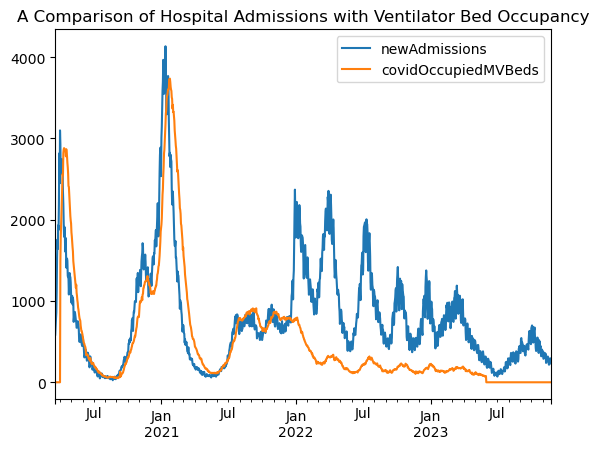

## Download current data

Give your users an option to refresh the dataset - a "refresh" button will do. The button callback should
* call the code that accesses the API and download some fresh raw data;
* wrangle that data into a dataframe and update the corresponding (global) variable for plotting (here, ```df```);
* optionally: force a redraw of the graph and give the user some fredback.

Once you get it to work, you may want to wrap your API call inside an exception handler, so that the user is informed, the "canned" data are not overwritten and nothing crashes if for any reason the server cannot be reached or data are not available.

After you refresh the data, graphs will not update until the user interacts with a widget. You can trick ```iPywidgets``` into redrawing the graph by simulating interaction, as in the ```refresh_graph``` function we define in the Graph and Analysis section below.

In this example, clicking on the button below just generates some more random data and refreshes the graph. The button should read *Fetch Data*. If you see anything else, take a deep breath :)

In [49]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    """ Accesses the PHE API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
    

    from uk_covid19 import Cov19API
    import json

    filters = [
        'areaType=nation',
        'areaName=England'
    ]

    structure = {
        "date": "date",
        "newAdmissions": "newAdmissions",
        "covidOccupiedMVBeds": "covidOccupiedMVBeds"
    }

    api = Cov19API(filters=filters, structure=structure)
    hosptital = api.get_json()

    return hosptital

In [50]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # The function needs to be adapted to your graph; you can omit this call
    # in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. If you are 
    # implementing error handling, you can use icons "unlink" or "times" and 
    # change the button text to "Unavailable" when the api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='Refresh data', # you may want to change this...
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='exclamation-triangle'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='danger', description='Refresh data', icon='exclamation-triangle', style=ButtonStyle(), to…

## Graphs and Analysis

Include at least one graph with interactive controls, as well as some instructions for the user and/or comments on what the graph represents and how it should be explored (this example shows two random walks)

In [51]:
import matplotlib.pyplot as plt
import ipywidgets as wdg

def plot_random_walk(walk, scale):
    """ Our sample graph plotting function """
    if scale == 'linear':
        df[walk].plot()
    else:
        df[walk].plot(logy=True)
    plt.show()  # important! update won't work properly without this

# a sample widget
whichwalk = wdg.Dropdown(
    options=['newAdmissions', 'covidOccupiedMVBeds'], 
    value='newAdmissions',
    description='Walk no: ',
    disabled=False,
)

# Add a scale selection widget
scale = wdg.RadioButtons(
    options=['linear', 'log'],
    value='linear',
    description='Scale: ',
    disabled=False,
)

def refresh_graph():
    """ We change the value of the widget to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current = whichwalk.value
    if current == whichwalk.options[0]:
        other = whichwalk.options[1]
    else:
        other = whichwalk.options[0]
    whichwalk.value = other  # forces the redraw
    whichwalk.value = current  # now we can change it back

# connect the plotting function and the widgets
graph = wdg.interactive_output(plot_random_walk, {'walk': whichwalk, 'scale': scale})

# actually display the widgets and the graph
display(whichwalk, scale, graph)

Dropdown(description='Walk no: ', options=('newAdmissions', 'covidOccupiedMVBeds'), value='newAdmissions')

RadioButtons(description='Scale: ', options=('linear', 'log'), value='linear')

Output()

## Deploying the dashboard

Once your code is ready and you are satisfied with the appearance of the graphs, replace all the text boxes above with the explanations you would like a dashboard user to see. The next step is deploying the dashboard online - there are several [options](https://voila.readthedocs.io/en/stable/deploy.html) for this, we suggest deploying as a [Binder](https://mybinder.org/). This is basically the same technique that has been used to package this tutorial and to deploy this template dashboard. The instructions may seem a bit involved, but the actual steps are surprisingly easy - we will be going through them together during a live session. You will need an account on [GitHub](https://github.com/) for this - if you don't have one already, now it's the time to create it. 

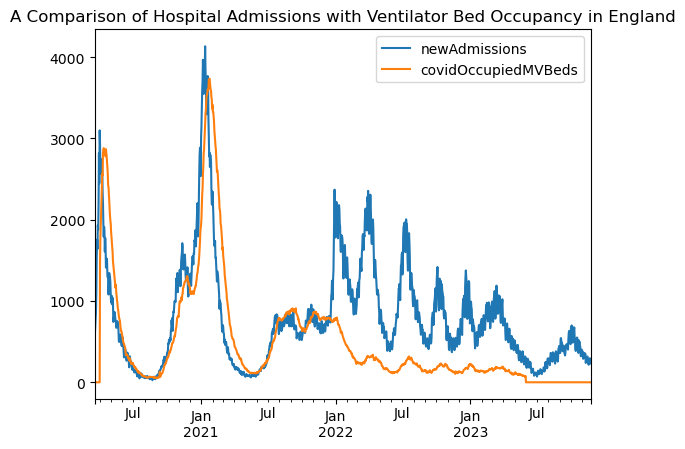

In [53]:
#here is the overall graph to show a comparion of  Hospital Admissions with Ventilator Bed Occupancy
df = wrangle_data(jsondata)
df.plot()
plt.title('A Comparison of Hospital Admissions with Ventilator Bed Occupancy in England')
plt.show()

**Author and Copyright Notice** Remember that if you deploy this dashboard as a Binder it will be publicly accessible. Take credit for your work! Also acknowledge your sources: Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england) and on the [DIY Covid Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash), Copyright (C) Fabrizio Smeraldi 2020,2023. Released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).